In [1]:
import os
import sys
import time
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB4
from sklearn.model_selection import train_test_split
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [2]:
import plotly.graph_objs as go
from plotly.offline import iplot
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_theme(style='whitegrid', palette='viridis', font_scale=1.2)

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Deepfake Detection Deep Learning Model



1. Importing Dataset from Kaggle

Dataset source: https://www.kaggle.com/datasets/dagnelies/deepfake-faces


In [3]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download -d dagnelies/deepfake-faces

!unzip "deepfake-faces.zip"

Streaming output truncated to the last 5000 lines.
  inflating: faces_224/yppwksjuui.jpg  
  inflating: faces_224/yppybofyww.jpg  
  inflating: faces_224/ypqjxdwawy.jpg  
  inflating: faces_224/ypqsxalhkw.jpg  
  inflating: faces_224/ypqxbbydxe.jpg  
  inflating: faces_224/ypqzrivawi.jpg  
  inflating: faces_224/yprdarrkit.jpg  
  inflating: faces_224/yprhthcacq.jpg  
  inflating: faces_224/yprmkhffdi.jpg  
  inflating: faces_224/yprnmqkhga.jpg  
  inflating: faces_224/yprqkgcoid.jpg  
  inflating: faces_224/yprsoygtjn.jpg  
  inflating: faces_224/yprxcbpmaj.jpg  
  inflating: faces_224/yprxtgidkk.jpg  
  inflating: faces_224/ypsbicsrsf.jpg  
  inflating: faces_224/ypsfvpanpn.jpg  
  inflating: faces_224/ypsgzbgbaz.jpg  
  inflating: faces_224/ypskfnxajx.jpg  
  inflating: faces_224/ypskxfumwo.jpg  
  inflating: faces_224/ypslvqfsrd.jpg  
  inflating: faces_224/ypsmruzzyt.jpg  
  inflating: faces_224/ypsqgodnrn.jpg  
  inflating: faces_224/ypsydrqqsl.jpg  
  inflating: faces_224/yptcha

Loading data

In [5]:
dataset = pd.read_csv('metadata.csv')
dataset.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [6]:
def get_dataset_brief(df):
    df_brief = pd.DataFrame(df.dtypes, columns=['dataType'])
    df_brief['count'] = df.count().values
    df_brief['unique'] = df.nunique().values
    df_brief['missing#'] = df.isna().sum()
    df_brief['missing%'] = df.isna().sum() / len(df)
    return df_brief

get_dataset_brief(dataset).style.background_gradient('RdBu')

,dataType,count,unique,missing#,missing%
videoname,object,95634,95634,0,0.000000
original_width,int64,95634,31,0,0.000000
original_height,int64,95634,34,0,0.000000
label,object,95634,2,0,0.000000
original,object,79341,16955,16293,0.170368


In [7]:
real_df = dataset[dataset['label'] == 'REAL']
fake_df = dataset[dataset['label'] == 'FAKE']

sample_size = 8000

real_df = real_df.sample(sample_size, random_state=42)
fake_df = fake_df.sample(sample_size, random_state=42)

sample_dataset = pd.concat([real_df, fake_df])

In [8]:
Train_set, Test_set = train_test_split(sample_dataset, test_size=0.2, random_state=42, stratify=sample_dataset['label'])
Train_set, Val_set = train_test_split(Train_set, test_size=0.3, random_state=42, stratify=Train_set['label'])

print(f'Train Set: {Train_set.shape}')
print(f'Validation Set: {Val_set.shape}')
print(f'Test Set: {Test_set.shape}')

Train Set: (8960, 5)
Validation Set: (3840, 5)
Test Set: (3200, 5)


In [9]:
def plot_dataset_info(train_set, val_set, test_set):
    sets = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['#ff0000', '#00ff00']

    y = {
        'REAL': [np.sum(train_set == 'REAL'), np.sum(val_set == 'REAL'), np.sum(test_set == 'REAL')],
        'FAKE': [np.sum(train_set == 'FAKE'), np.sum(val_set == 'FAKE'), np.sum(test_set == 'FAKE')]
    }

    trace0 = go.Bar(x=sets, y=y['REAL'], name='REAL', marker={'color': colors[0]}, opacity=0.7)
    trace1 = go.Bar(x=sets, y=y['FAKE'], name='FAKE', marker={'color': colors[1]}, opacity=0.7)

    data = [trace0, trace1]
    layout = go.Layout(title='Count of images in each set:', xaxis={'title': 'Set'}, yaxis={'title': 'Count'})

    fig = go.Figure(data, layout)
    iplot(fig)

plot_dataset_info(np.array(Train_set['label']), np.array(Val_set['label']), np.array(Test_set['label']))

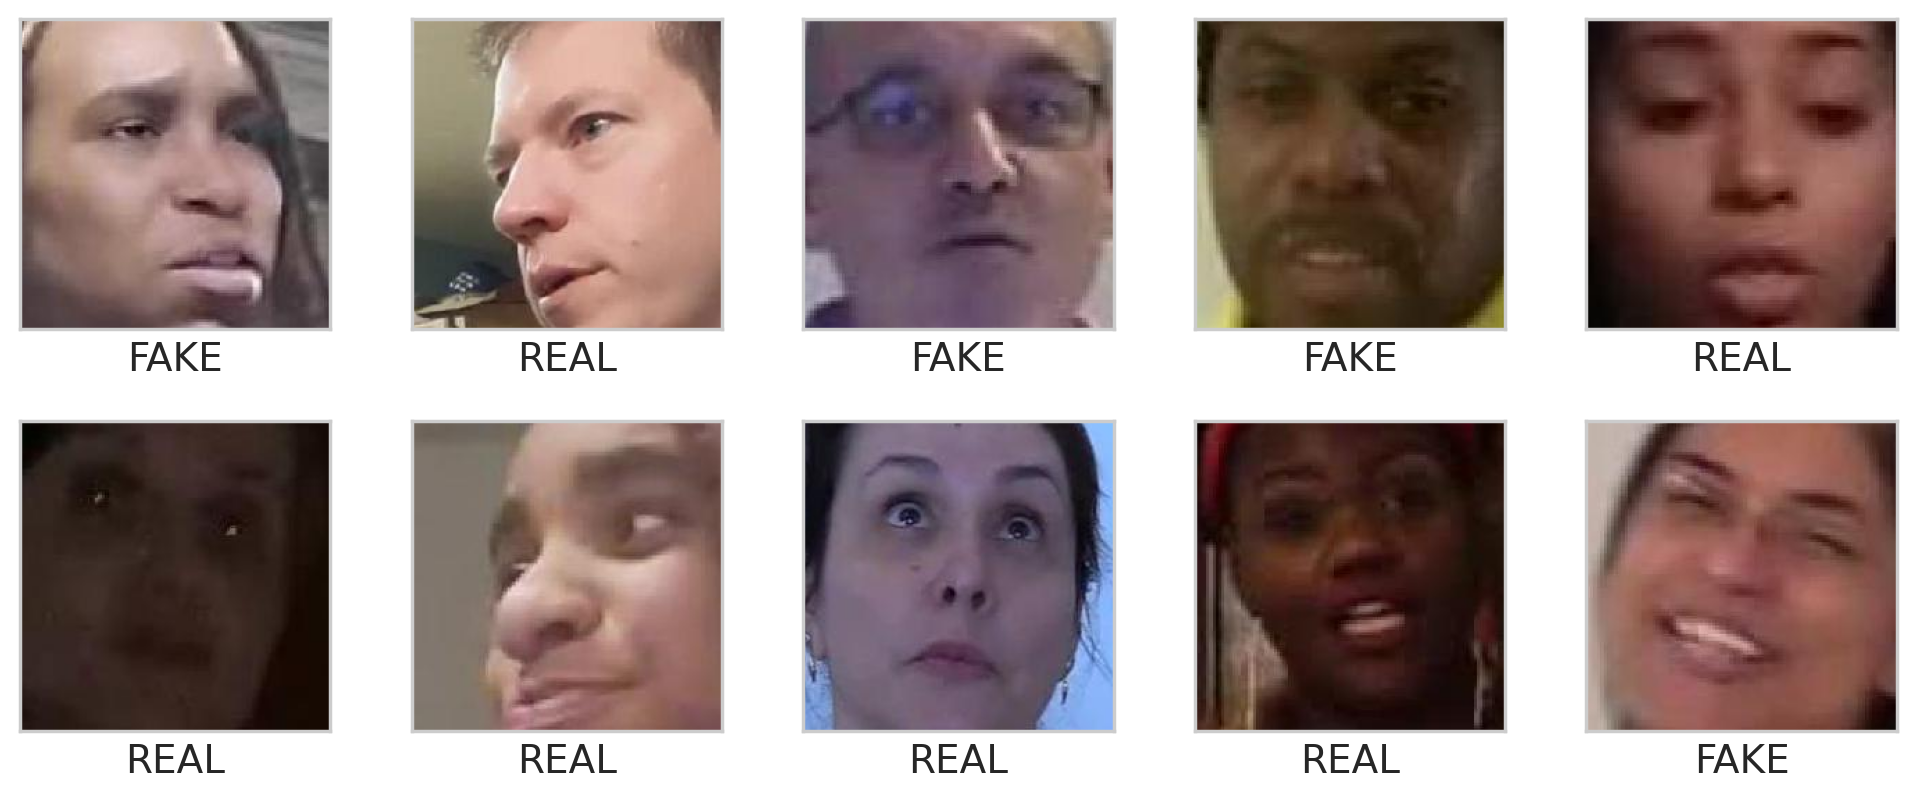

In [10]:
plt.figure(figsize=(10,10), dpi=100)
for idx,i in enumerate(Train_set.index[5:15]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = cv2.imread('/content/faces_224/'+Train_set.loc[i,'videoname'][:-4]+'.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)

    plt.xlabel('FAKE' if Train_set.loc[i,'label']=='FAKE' else 'REAL')

plt.tight_layout()
plt.show()

In [11]:
def get_data(set_name):
    images, labels = [], []
    for (img, imgclass) in zip(set_name['videoname'], set_name['label']):
        images.append(cv2.imread('/content/faces_224/'+img[:-4]+'.jpg'))
        labels.append(1 if imgclass == 'FAKE' else 0)
    return np.array(images), np.array(labels)

In [12]:
X_train, y_train = get_data(Train_set)
X_val, y_val = get_data(Val_set)
X_test, y_test = get_data(Test_set)

In [ ]:
%%time

tf.keras.backend.clear_session()
tf.random.set_seed(42)

batch_size = 16

preprocess = tf.keras.applications.efficientnet.preprocess_input

train_set_raw = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_set_raw = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_set_raw = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_set = train_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(tf.cast(X, tf.float32)), y)).batch(batch_size)

In [14]:
base_model = EfficientNetB4(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation="sigmoid")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

71686520/71686520 [==============================] - 4s 0us/step


In [15]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.1),
])

In [22]:
from tensorflow.keras.regularizers import l2

inputs = tf.keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(inputs, outputs)

In [23]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [24]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 efficientnetb4 (Functional  (None, 7, 7, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d_2  (None, 1792)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 256)               459008    
                                                                 
 dense_4 (Dense)             (None, 1)                 257 

In [25]:
%%time

history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=45
)

Epoch 1/45
560/560 [==============================] - 265s 374ms/step - loss: 1.1050 - accuracy: 0.5972 - val_loss: 1.0903 - val_accuracy: 0.6195
Epoch 2/45
560/560 [==============================] - 206s 367ms/step - loss: 1.0280 - accuracy: 0.6823 - val_loss: 1.0272 - val_accuracy: 0.6768
Epoch 3/45
560/560 [==============================] - 206s 367ms/step - loss: 0.9481 - accuracy: 0.7394 - val_loss: 0.9442 - val_accuracy: 0.7380
Epoch 4/45
560/560 [==============================] - 203s 363ms/step - loss: 0.8997 - accuracy: 0.7656 - val_loss: 0.8973 - val_accuracy: 0.7654
Epoch 5/45
560/560 [==============================] - 203s 363ms/step - loss: 0.8223 - accuracy: 0.8052 - val_loss: 0.8850 - val_accuracy: 0.7669
Epoch 6/45
560/560 [==============================] - 206s 367ms/step - loss: 0.7764 - accuracy: 0.8260 - val_loss: 0.8980 - val_accuracy: 0.7635
Epoch 7/45
560/560 [==============================] - 206s 367ms/step - loss: 0.7488 - accuracy: 0.8403 - val_loss: 0.7801 -

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
model.save('/content/drive/MyDrive/SavedModels/model0505.h5')

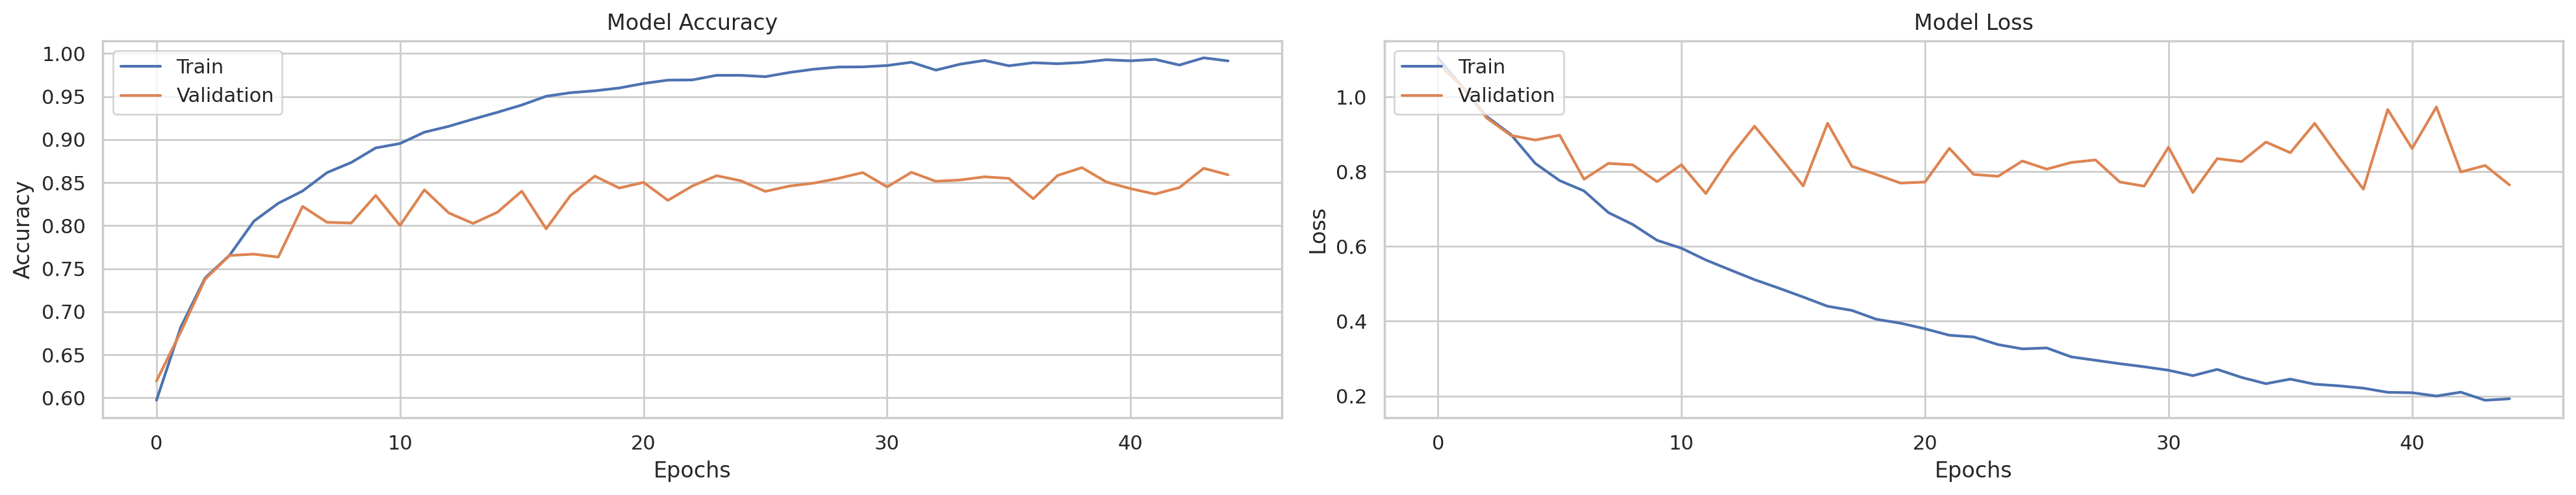

In [33]:
sns.set(style="whitegrid")
# plt.figure(figsize=(12, 6))
plt.figure(figsize=(20, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

100/100 [==============================] - 30s 177ms/step - loss: 0.7079 - accuracy: 0.8672

Test Loss: 0.7079
Test Accuracy: 0.8672


100/100 [==============================] - 19s 143ms/step


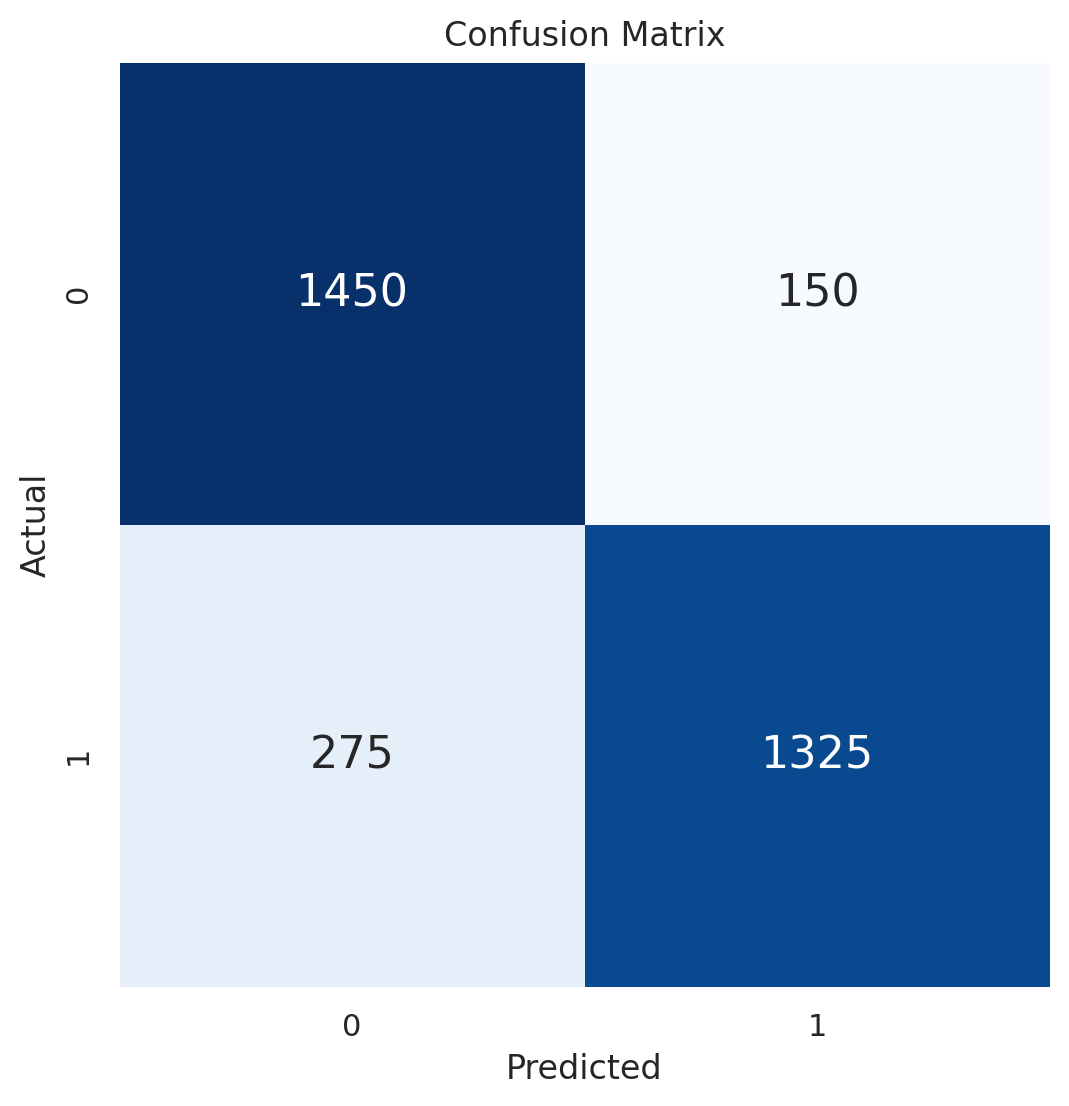

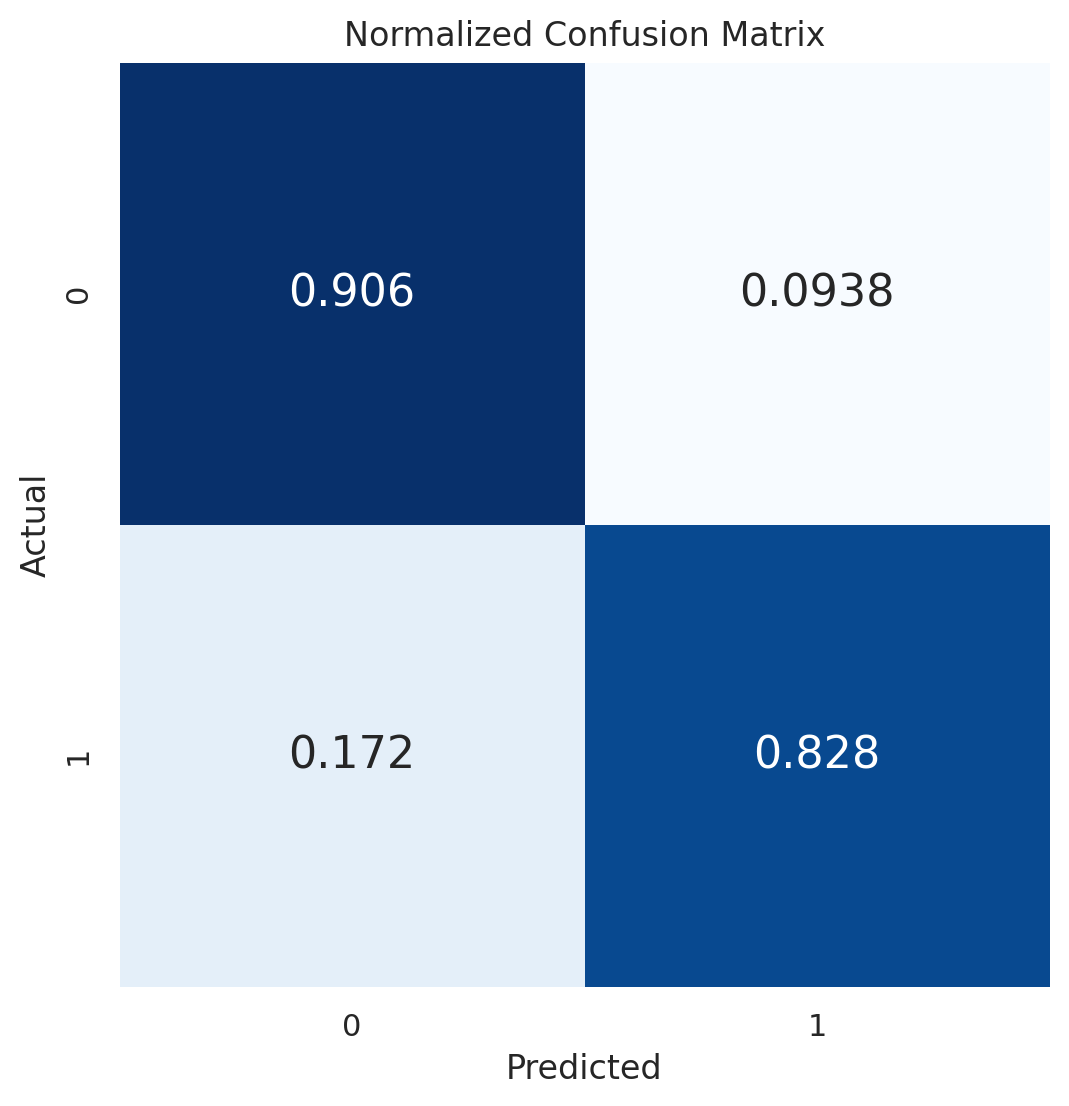

In [30]:
from sklearn.metrics import confusion_matrix, classification_report

y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



plt.figure(figsize=(6, 6))
sns.heatmap(cmn, annot=True, fmt='.3g', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1600
           1       0.90      0.83      0.86      1600

    accuracy                           0.87      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.87      0.87      0.87      3200



In [34]:
model.save('model0505.h5')